In [38]:
import os
import sys
from glob import glob
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torchvision.transforms.functional as F

import cv2
import monai
from monai.losses import DiceLoss, DiceCELoss
from monai.metrics import DiceMetric
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    RandFlipd,
    RandShiftIntensityd,
    RandRotate90d,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
import SimpleITK as sitk
from scipy.spatial.distance import directed_hausdorff

from TransUNet.networks.vit_seg_modeling import CONFIGS as CONFIGS_ViT_seg
from TransUNet.networks.vit_seg_modeling import VisionTransformer as ViT_seg

In [3]:
import os
from glob import glob
import cv2 as cv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset

In [ ]:
# Create Dataframe
def create_df(data_dir):
    images_paths = []
    masks_paths = glob(f'{data_dir}/*/*_mask*')
    for i in masks_paths:
        images_paths.append(i.replace('_mask', ''))
    df = pd.DataFrame(data= {'images': images_paths, 'masks': masks_paths})
    return df

data_dir = '../data/kaggle_3m'
df = create_df(data_dir)
df.head()

,images,masks
0,./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...,./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...
1,./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...,./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...
2,./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...,./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...
3,./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...,./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...
4,./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...,./data/kaggle_3m/TCGA_HT_A5RC_19990831/TCGA_HT...


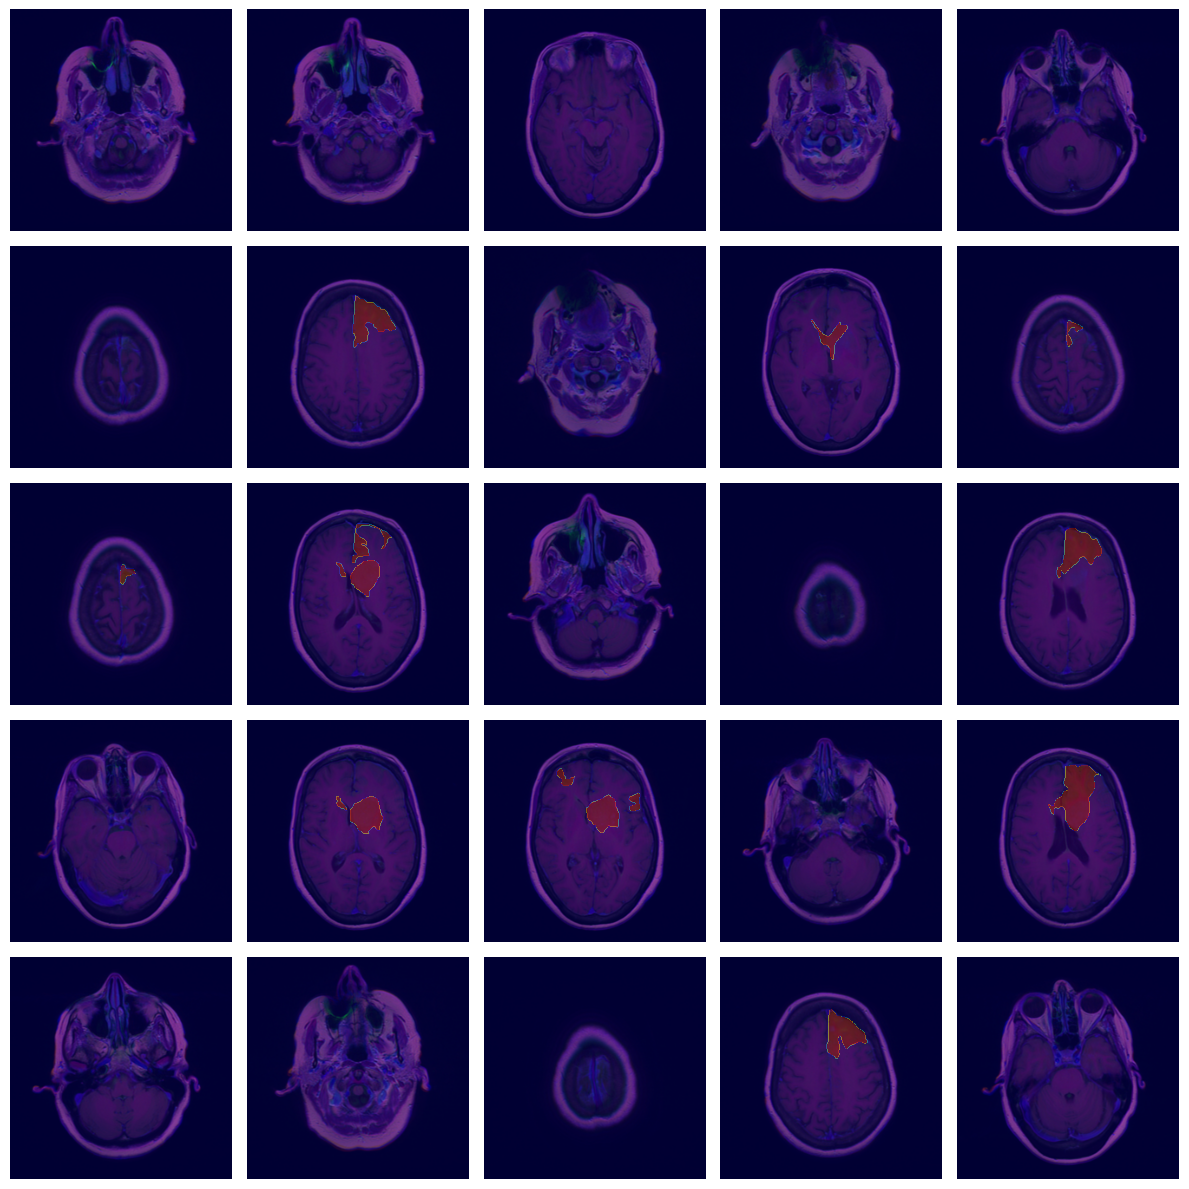

In [5]:
# Function to display images and masks
def show_images(images, masks):
    plt.figure(figsize=(12, 12))
    for i in range(25):
        plt.subplot(5, 5, i + 1)

        img_path = images[i]
        mask_path = masks[i]

        # Read and convert image to RGB
        image = cv.imread(img_path)
        image = cv.cvtColor(image, cv.COLOR_BGR2RGB)

        # Read the mask
        mask = cv.imread(mask_path, cv.IMREAD_GRAYSCALE) 

        # Display the image
        plt.imshow(image)
        plt.imshow(mask, cmap="jet", alpha=0.4) 
        plt.axis("off")

    plt.tight_layout()
    plt.show()

show_images(list(df["images"]), list(df["masks"]))

In [ ]:
class MaskBinarize:
    def __call__(self, msk):
        msk = (msk > 0.5).float()  
        return msk
    
def img_to_tensor(df, mask=False):#, image_size=(224, 224)):
    if mask:
        transform = transforms.Compose([
            #transforms.Resize(image_size),  
            transforms.ToTensor(),          
            MaskBinarize()
        ])
    else:
        transform = transforms.Compose([
            #transforms.Resize(image_size),  
            transforms.ToTensor(),          
            #MaskBinarize()
        ])
    
    image_tensors = []
    
    for img_path in df:
        try:
            if mask:
                img = Image.open(img_path).convert("L")  # grayscale transform
                img_tensor = transform(img)  # to tensor
                image_tensors.append(img_tensor)
            else:
                img = Image.open(img_path)
                print(f"Image path: {img_path}, original size: {img.size}")
                img = Image.open(img_path).convert("L")  # RGB transform
                img_tensor = transform(img)  # to tensor
                image_tensors.append(img_tensor)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

    if image_tensors:
        # (batch, C, H, W)
        image_tensors = torch.stack(image_tensors)
        print(f"Loaded {len(image_tensors)} images successfully.")
        return image_tensors
    else:
        print("No valid images were loaded.")
        return None

image_tensors = img_to_tensor(df["images"])
mask_tensors = img_to_tensor(df["masks"], mask=True)

if image_tensors is not None:
    print(f"Final tensor shape: {image_tensors.shape}")  # (N, C, H, W)


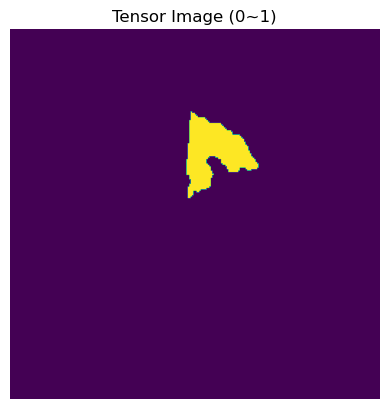

In [15]:
np_img = mask_tensors[6].permute(1, 2, 0).numpy()  # shape: [H, W, 1]

# print test
plt.imshow(np_img)
plt.axis('off')
plt.title("Tensor Image (0~1)")
plt.show()

In [16]:
# data split: 80/10/10
train_img, test_img, train_mask, test_mask = train_test_split(image_tensors, mask_tensors, test_size = 0.1)
train_img, val_img, train_mask, val_mask = train_test_split(train_img, train_mask, test_size = 0.1)

In [17]:
train_dataset = TensorDataset(train_img, train_mask)
val_dataset = TensorDataset(val_img, val_mask)
test_dataset = TensorDataset(test_img, test_mask)

trainloader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=2)
testloader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

# -------------------------
# Model 1 UNet

In [21]:
def dice_coefficient(y_pred, y_true):
    intersection = torch.sum(y_pred * y_true)
    union = torch.sum(y_pred) + torch.sum(y_true) + 1e-6

    dice = 2 * intersection / union

    return dice

In [25]:
def compute_metrics(pred, target, eps=1e-6):
    """
    pred: binary prediction tensor (0/1), same shape as target
    target: ground truth mask (0/1)
    """
    TP = torch.sum(pred * target)
    FP = torch.sum(pred * (1 - target))
    FN = torch.sum((1 - pred) * target)

    iou = TP / (TP + FP + FN + eps)
    recall = TP / (TP + FN + eps)

    return iou.item(), recall.item()


# -------------------------
# Model 2 TransUNet

In [ ]:


class DiceLoss(nn.Module):
    def __init__(self, smooth=1e-6):
        super(DiceLoss, self).__init__()
        self.smooth = smooth
    
    def forward(self, pred, true):
        pred = pred.view(-1)
        true = true.view(-1)
        intersection = (pred*true).sum()
        dice = (2*intersection + self.smooth) / (pred.sum() + true.sum() + self.smooth)
        return 1 - dice

class BCEDiceLoss(nn.Module):
    def __init__(self, bce_weight=0.5):
        super().__init__()
        self.bce = nn.BCELoss()
        self.dice = DiceLoss()
        self.bce_weight = bce_weight

    def forward(self, pred, true):
        bce_loss = self.bce(pred, true)
        dice_loss = self.dice(pred, true)
        return self.bce_weight * bce_loss + (1-self.bce_weight) * dice_loss
        

In [40]:
import os, urllib.request

os.makedirs("TransUNet/model/vit_checkpoint/imagenet21k", exist_ok=True)
url = "https://storage.googleapis.com/vit_models/imagenet21k/R50+ViT-B_16.npz"
save_path = "TransUNet/model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz"

urllib.request.urlretrieve(url, save_path)
print("✅ 权重文件下载完成：", save_path)


✅ 权重文件下载完成： TransUNet/model/vit_checkpoint/imagenet21k/R50+ViT-B_16.npz


In [ ]:
vit_name = 'R50-ViT-B_16'
config_vit = CONFIGS_ViT_seg[vit_name]
config_vit.n_classes = 1
config_vit.n_skip = 3

model = ViT_seg(config_vit, img_size=256, num_classes=1).cuda()
load_path = config_vit.pretrained_path.split('..')[-1]
load_path = 'TransUNet' + load_path

model.load_from(weights=np.load(load_path))
loss_function = BCEDiceLoss(bce_weight=0.5)
optimizer = torch.optim.Adam(model.parameters(), 1e-3)

load_pretrained: grid-size from 14 to 16


In [42]:
total_epoch = 200
best_dice = 0.0
patience = 10  # 可以调整
counter = 0
early_stop = False

print('Begin to train!!')
for epoch in range(total_epoch):
    if early_stop:
        print("Early stopping triggered at epoch", epoch)
        break

    model.train()
    epoch_loss = 0.0
    batch_idx = 0
    for img, mask in tqdm(trainloader):
        batch_idx += 1
        img, mask = img.cuda(), mask.cuda().float()
        optimizer.zero_grad()
        output = model(img)
        output = torch.sigmoid(output)
        
        loss = loss_function(output, mask)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= batch_idx
    print('Epoch {} loss: {:.4f}'.format(epoch, epoch_loss))

    if (epoch + 1) % 5 == 0:
        model.eval()
        print('Begin to validate!!')
        with torch.no_grad():
            val_loss = 0.0
            val_dice = 0.0
            val_idx = 0
            for val_img, val_mask in tqdm(valloader):
                val_idx += 1
                val_img, val_mask = val_img.cuda(), val_mask.cuda().float()
                val_output = model(val_img)
                val_output = torch.sigmoid(val_output)

                loss = loss_function(val_output, val_mask)
                val_loss += loss.item()
                val_dice += dice_coefficient(val_output, val_mask)
        val_loss /= val_idx
        val_dice /= val_idx

        print('Validation ended !!')
        print('Dice: {:.4f}, Loss: {:.4f}'.format(val_dice, val_loss))

        if val_dice > best_dice:
            best_dice = val_dice
            counter = 0
            torch.save(model.state_dict(), 'TransUNet_model.pth')
            print(f"✅ New best Dice {best_dice:.4f}, model saved.")
        else:
            counter += 1
            print(f"⚠️  No improvement. Early stop counter: {counter}/{patience}")
            if counter >= patience:
                early_stop = True

print('Training ended !!')


Begin to train!!


100%|██████████| 50/50 [01:02<00:00,  1.24s/it]


Epoch 0 loss: 0.3047


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 1 loss: 0.0840


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 2 loss: 0.0498


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 3 loss: 0.0397


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 4 loss: 0.0302
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


Validation ended !!
Dice: 0.3017, Loss: 0.0269
✅ New best Dice 0.3017, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 5 loss: 0.0416


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 6 loss: 0.0357


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 7 loss: 0.0310


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 8 loss: 0.0401


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 9 loss: 0.0285
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


Validation ended !!
Dice: 0.0546, Loss: 0.3314
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 10 loss: 0.0230


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 11 loss: 0.0208


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 12 loss: 0.0201


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 13 loss: 0.0185


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 14 loss: 0.0176
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.85it/s]


Validation ended !!
Dice: 0.3045, Loss: 0.0584
✅ New best Dice 0.3045, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 15 loss: 0.0167


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 16 loss: 0.0162


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 17 loss: 0.0147


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 18 loss: 0.0134


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 19 loss: 0.0131
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


Validation ended !!
Dice: 0.5929, Loss: 0.0173
✅ New best Dice 0.5929, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 20 loss: 0.0117


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 21 loss: 0.0134


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 22 loss: 0.0122


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 23 loss: 0.0110


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 24 loss: 0.0113
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.84it/s]


Validation ended !!
Dice: 0.6405, Loss: 0.0127
✅ New best Dice 0.6405, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 25 loss: 0.0106


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 26 loss: 0.0093


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 27 loss: 0.0092


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 28 loss: 0.0094


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 29 loss: 0.0084
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.80it/s]


Validation ended !!
Dice: 0.4460, Loss: 0.0439
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 30 loss: 0.0082


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 31 loss: 0.0077


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 32 loss: 0.0083


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 33 loss: 0.0071


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 34 loss: 0.0070
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Validation ended !!
Dice: 0.4104, Loss: 0.0361
⚠️  No improvement. Early stop counter: 2/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 35 loss: 0.0067


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 36 loss: 0.0064


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 37 loss: 0.0068


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 38 loss: 0.0061


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 39 loss: 0.0079
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.71it/s]


Validation ended !!
Dice: 0.4069, Loss: 0.0422
⚠️  No improvement. Early stop counter: 3/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 40 loss: 0.0088


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 41 loss: 0.0066


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 42 loss: 0.0064


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 43 loss: 0.0060


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 44 loss: 0.0066
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


Validation ended !!
Dice: 0.7546, Loss: 0.0110
✅ New best Dice 0.7546, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 45 loss: 0.0065


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 46 loss: 0.0057


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Epoch 47 loss: 0.0052


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 48 loss: 0.0049


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 49 loss: 0.0049
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Validation ended !!
Dice: 0.7091, Loss: 0.0136
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 50 loss: 0.0045


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 51 loss: 0.0051


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 52 loss: 0.0050


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 53 loss: 0.0047


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 54 loss: 0.0052
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


Validation ended !!
Dice: 0.5939, Loss: 0.0256
⚠️  No improvement. Early stop counter: 2/10


100%|██████████| 50/50 [00:42<00:00,  1.16it/s]


Epoch 55 loss: 0.0046


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 56 loss: 0.0046


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 57 loss: 0.0046


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 58 loss: 0.0044


100%|██████████| 50/50 [00:44<00:00,  1.13it/s]


Epoch 59 loss: 0.0048
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


Validation ended !!
Dice: 0.7957, Loss: 0.0102
✅ New best Dice 0.7957, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 60 loss: 0.0041


100%|██████████| 50/50 [00:43<00:00,  1.15it/s]


Epoch 61 loss: 0.0041


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 62 loss: 0.0040


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 63 loss: 0.0050


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 64 loss: 0.0053
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Validation ended !!
Dice: 0.7419, Loss: 0.0101
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:47<00:00,  1.06it/s]


Epoch 65 loss: 0.0042


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 66 loss: 0.0038


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 67 loss: 0.0036


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 68 loss: 0.0039


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


Epoch 69 loss: 0.0041
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.70it/s]


Validation ended !!
Dice: 0.7509, Loss: 0.0128
⚠️  No improvement. Early stop counter: 2/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 70 loss: 0.0039


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 71 loss: 0.0035


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 72 loss: 0.0032


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 73 loss: 0.0032


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 74 loss: 0.0034
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Validation ended !!
Dice: 0.6442, Loss: 0.0204
⚠️  No improvement. Early stop counter: 3/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 75 loss: 0.0035


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


Epoch 76 loss: 0.0033


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 77 loss: 0.0030


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 78 loss: 0.0030


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 79 loss: 0.0032
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.74it/s]


Validation ended !!
Dice: 0.5234, Loss: 0.0425
⚠️  No improvement. Early stop counter: 4/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 80 loss: 0.0031


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 81 loss: 0.0030


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 82 loss: 0.0027


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 83 loss: 0.0036


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 84 loss: 0.0040
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.75it/s]


Validation ended !!
Dice: 0.6315, Loss: 0.0213
⚠️  No improvement. Early stop counter: 5/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 85 loss: 0.0048


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 86 loss: 0.0052


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 87 loss: 0.0044


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 88 loss: 0.0033


100%|██████████| 50/50 [00:50<00:00,  1.01s/it]


Epoch 89 loss: 0.0029
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.57it/s]


Validation ended !!
Dice: 0.7264, Loss: 0.0205
⚠️  No improvement. Early stop counter: 6/10


100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


Epoch 90 loss: 0.0026


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 91 loss: 0.0027


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 92 loss: 0.0026


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 93 loss: 0.0024


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 94 loss: 0.0024
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.74it/s]


Validation ended !!
Dice: 0.8116, Loss: 0.0117
✅ New best Dice 0.8116, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 95 loss: 0.0023


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 96 loss: 0.0023


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 97 loss: 0.0022


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 98 loss: 0.0022


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 99 loss: 0.0022
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.78it/s]


Validation ended !!
Dice: 0.8197, Loss: 0.0127
✅ New best Dice 0.8197, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 100 loss: 0.0021


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 101 loss: 0.0021


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 102 loss: 0.0021


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 103 loss: 0.0020


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 104 loss: 0.0020
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Validation ended !!
Dice: 0.7440, Loss: 0.0176
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


Epoch 105 loss: 0.0019


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 106 loss: 0.0019


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 107 loss: 0.0019


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 108 loss: 0.0019


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 109 loss: 0.0018
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.79it/s]


Validation ended !!
Dice: 0.8486, Loss: 0.0105
✅ New best Dice 0.8486, model saved.


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 110 loss: 0.0019


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 111 loss: 0.0018


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 112 loss: 0.0017


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 113 loss: 0.0018


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 114 loss: 0.0017
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.82it/s]


Validation ended !!
Dice: 0.8337, Loss: 0.0128
⚠️  No improvement. Early stop counter: 1/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 115 loss: 0.0017


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 116 loss: 0.0016


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 117 loss: 0.0017


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 118 loss: 0.0017


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 119 loss: 0.0017
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


Validation ended !!
Dice: 0.7159, Loss: 0.0280
⚠️  No improvement. Early stop counter: 2/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 120 loss: 0.0016


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 121 loss: 0.0017


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 122 loss: 0.0016


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 123 loss: 0.0015


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 124 loss: 0.0014
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


Validation ended !!
Dice: 0.8320, Loss: 0.0123
⚠️  No improvement. Early stop counter: 3/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 125 loss: 0.0014


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 126 loss: 0.0014


100%|██████████| 50/50 [00:44<00:00,  1.12it/s]


Epoch 127 loss: 0.0014


100%|██████████| 50/50 [00:43<00:00,  1.16it/s]


Epoch 128 loss: 0.0014


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 129 loss: 0.0156
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


Validation ended !!
Dice: 0.0000, Loss: 0.6487
⚠️  No improvement. Early stop counter: 4/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 130 loss: 0.0304


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 131 loss: 0.0211


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 132 loss: 0.0179


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 133 loss: 0.0154


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 134 loss: 0.0139
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


Validation ended !!
Dice: 0.6494, Loss: 0.0148
⚠️  No improvement. Early stop counter: 5/10


100%|██████████| 50/50 [00:43<00:00,  1.14it/s]


Epoch 135 loss: 0.0126


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 136 loss: 0.0118


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 137 loss: 0.0104


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 138 loss: 0.0098


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 139 loss: 0.0097
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.76it/s]


Validation ended !!
Dice: 0.5514, Loss: 0.0215
⚠️  No improvement. Early stop counter: 6/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 140 loss: 0.0088


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 141 loss: 0.0080


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 142 loss: 0.0075


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 143 loss: 0.0073


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 144 loss: 0.0070
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.77it/s]


Validation ended !!
Dice: 0.7511, Loss: 0.0111
⚠️  No improvement. Early stop counter: 7/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 145 loss: 0.0068


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 146 loss: 0.0059


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 147 loss: 0.0057


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 148 loss: 0.0063


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 149 loss: 0.0057
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.81it/s]


Validation ended !!
Dice: 0.5059, Loss: 0.0338
⚠️  No improvement. Early stop counter: 8/10


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 150 loss: 0.0056


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 151 loss: 0.0051


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 152 loss: 0.0054


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 153 loss: 0.0048


100%|██████████| 50/50 [00:42<00:00,  1.17it/s]


Epoch 154 loss: 0.0049
Begin to validate!!


100%|██████████| 6/6 [00:03<00:00,  1.83it/s]


Validation ended !!
Dice: 0.7767, Loss: 0.0107
⚠️  No improvement. Early stop counter: 9/10


 94%|█████████▍| 47/50 [00:40<00:02,  1.21it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [43]:
model.load_state_dict(torch.load('TransUNet_model.pth'))
model.cuda()
model.eval()
batch_idx = 0
test_dice = 0.0
test_hd = 0.0
test_iou = 0.0
test_recall = 0.0

for img, mask in tqdm(testloader):
    batch_idx += 1
    img = img.cuda()
    mask = mask.cuda().float()

    with torch.no_grad():
        raw_output = torch.sigmoid(model(img))
        binary_output = (raw_output > 0.5).float()

        # Dice
        test_dice += dice_coefficient(binary_output, mask)

        # IoU & Recall
        iou, recall = compute_metrics(binary_output, mask)
        test_iou += iou
        test_recall += recall

        # Hausdorff Distance
        hd_output = binary_output.cpu().detach().numpy()
        hd_mask = mask.cpu().detach().numpy()
        hd = 0.0
        for i in range(binary_output.shape[0]):
            hd += directed_hausdorff(hd_output[i].squeeze(), hd_mask[i].squeeze())[0]
        test_hd += hd / binary_output.shape[0]

# Final averaged metrics
test_dice /= batch_idx
test_iou /= batch_idx
test_recall /= batch_idx
test_hd /= batch_idx

print(f'During test of TransUNet_model :\n'
      f'  Dice:   {test_dice:.4f}\n'
      f'  IoU:    {test_iou:.4f}\n'
      f'  Recall: {test_recall:.4f}\n'
      f'  HD:     {test_hd:.4f} pixels')


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
100%|██████████| 7/7 [00:12<00:00,  1.78s/it]

During test of TransUNet_model :
  Dice:   0.8631
  IoU:    0.7625
  Recall: 0.8380
  HD:     1.2667 pixels


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


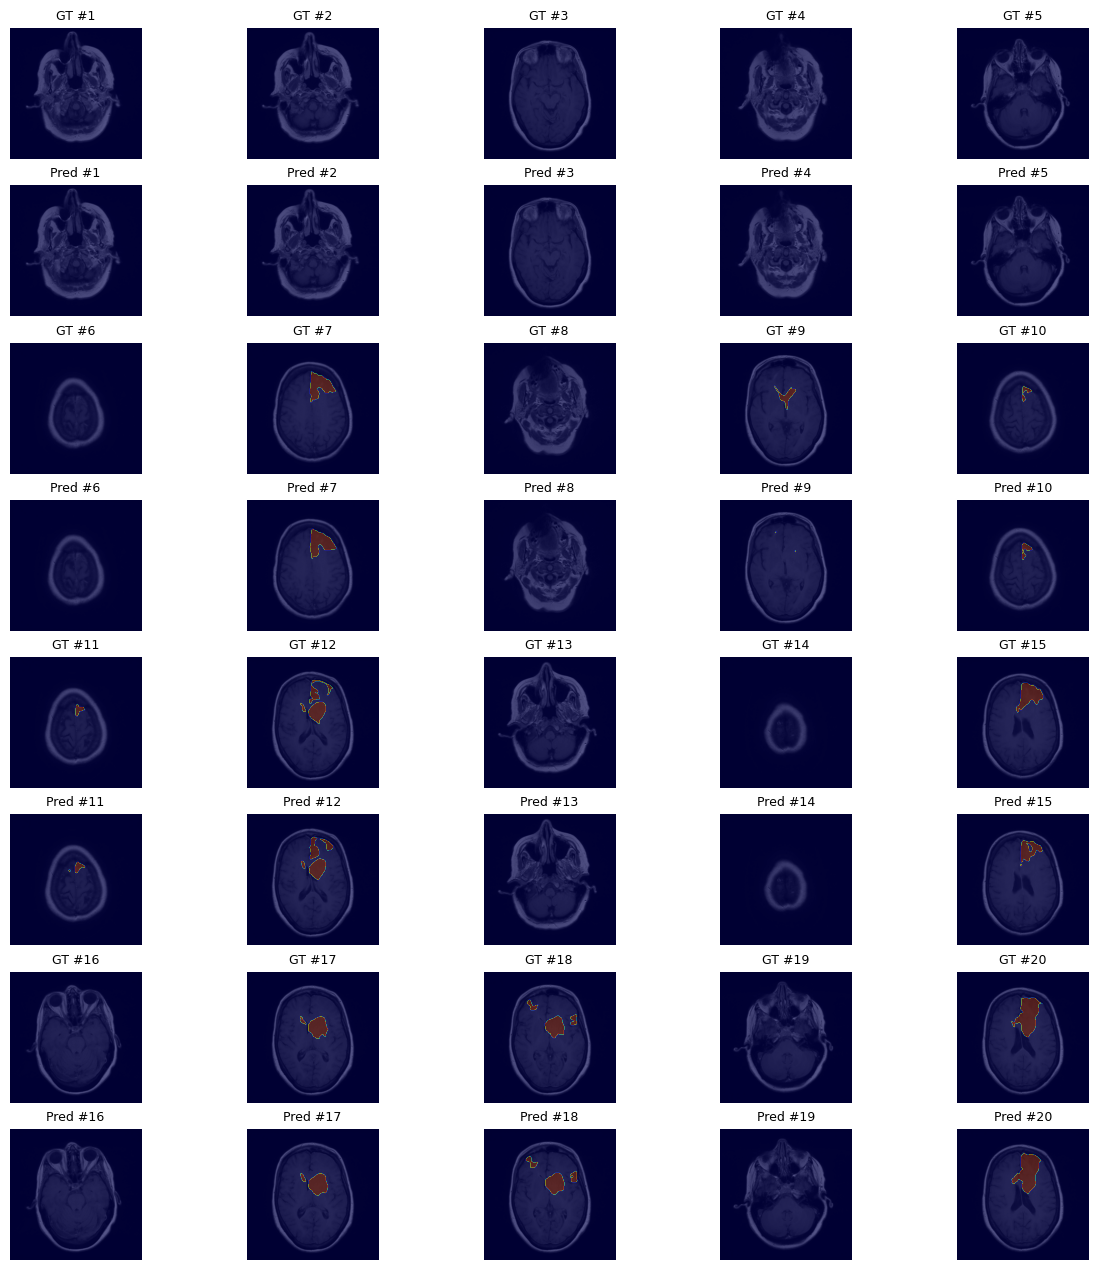

In [44]:
show_predictions_vertical_pairs(model, list(df["images"]), list(df["masks"]), num_groups=20, groups_per_row=5)


# -------------------------
# Model 4 SwinUNETR

In [ ]:
from monai.networks.nets import SwinUNETR
import torch.nn as nn

model = SwinUNETR(
    img_size=(256, 256),     
    in_channels=1,           
    out_channels=1,          
    spatial_dims=2      
).cuda()

loss_function = BCEDiceLoss(bce_weight=0.5)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)


monai.networks.nets.swin_unetr SwinUNETR.__init__:img_size: Argument `img_size` has been deprecated since version 1.3. It will be removed in version 1.5. The img_size argument is not required anymore and checks on the input size are run during forward().


In [50]:
total_epoch = 200
best_dice = 0.0
patience = 10  # 可以调整
counter = 0
early_stop = False

print('Begin to train!!')
for epoch in range(total_epoch):
    if early_stop:
        print("Early stopping triggered at epoch", epoch)
        break

    model.train()
    epoch_loss = 0.0
    batch_idx = 0
    for img, mask in tqdm(trainloader):
        batch_idx += 1
        img, mask = img.cuda(), mask.cuda().float()
        optimizer.zero_grad()
        output = model(img)
        output = torch.sigmoid(output)
        
        loss = loss_function(output, mask)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
    epoch_loss /= batch_idx
    print('Epoch {} loss: {:.4f}'.format(epoch, epoch_loss))

    if (epoch + 1) % 5 == 0:
        model.eval()
        print('Begin to validate!!')
        with torch.no_grad():
            val_loss = 0.0
            val_dice = 0.0
            val_idx = 0
            for val_img, val_mask in tqdm(valloader):
                val_idx += 1
                val_img, val_mask = val_img.cuda(), val_mask.cuda().float()
                val_output = model(val_img)
                val_output = torch.sigmoid(val_output)

                loss = loss_function(val_output, val_mask)
                val_loss += loss.item()
                val_dice += dice_coefficient(val_output, val_mask)
        val_loss /= val_idx
        val_dice /= val_idx

        print('Validation ended !!')
        print('Dice: {:.4f}, Loss: {:.4f}'.format(val_dice, val_loss))

        if val_dice > best_dice:
            best_dice = val_dice
            counter = 0
            torch.save(model.state_dict(), 'SwinUNETR_model.pth')
            print(f"✅ New best Dice {best_dice:.4f}, model saved.")
        else:
            counter += 1
            print(f"⚠️  No improvement. Early stop counter: {counter}/{patience}")
            if counter >= patience:
                early_stop = True

print('Training ended !!')


Begin to train!!


100%|██████████| 50/50 [00:30<00:00,  1.64it/s]


Epoch 0 loss: 0.5753


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 1 loss: 0.3868


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 2 loss: 0.3404


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 3 loss: 0.3089


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 4 loss: 0.2808
Begin to validate!!


100%|██████████| 6/6 [00:02<00:00,  2.24it/s]


Validation ended !!
Dice: 0.0376, Loss: 0.2674
✅ New best Dice 0.0376, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 5 loss: 0.2581


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 6 loss: 0.2392


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 7 loss: 0.2234


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 8 loss: 0.2096


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 9 loss: 0.1975
Begin to validate!!


100%|██████████| 6/6 [00:02<00:00,  2.44it/s]


Validation ended !!
Dice: 0.0719, Loss: 0.1923
✅ New best Dice 0.0719, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 10 loss: 0.1867


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 11 loss: 0.1769


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 12 loss: 0.1681


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 13 loss: 0.1599


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 14 loss: 0.1525
Begin to validate!!


100%|██████████| 6/6 [00:02<00:00,  2.42it/s]


Validation ended !!
Dice: 0.0905, Loss: 0.1515
✅ New best Dice 0.0905, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 15 loss: 0.1457


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 16 loss: 0.1396


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 17 loss: 0.1334


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 18 loss: 0.1274


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 19 loss: 0.1219
Begin to validate!!


100%|██████████| 6/6 [00:02<00:00,  2.35it/s]


Validation ended !!
Dice: 0.1192, Loss: 0.1223
✅ New best Dice 0.1192, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 20 loss: 0.1169


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 21 loss: 0.1121


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 22 loss: 0.1076


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 23 loss: 0.1034


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 24 loss: 0.0995
Begin to validate!!


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


Validation ended !!
Dice: 0.1415, Loss: 0.1015
✅ New best Dice 0.1415, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 25 loss: 0.0957


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 26 loss: 0.0922


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 27 loss: 0.0888


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 28 loss: 0.0855


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 29 loss: 0.0825
Begin to validate!!


100%|██████████| 6/6 [00:02<00:00,  2.38it/s]


Validation ended !!
Dice: 0.1658, Loss: 0.0854
✅ New best Dice 0.1658, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 30 loss: 0.0795


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 31 loss: 0.0766


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 32 loss: 0.0739


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 33 loss: 0.0714


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 34 loss: 0.0692
Begin to validate!!


100%|██████████| 6/6 [00:02<00:00,  2.28it/s]


Validation ended !!
Dice: 0.1946, Loss: 0.0735
✅ New best Dice 0.1946, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 35 loss: 0.0669


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 36 loss: 0.0645


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 37 loss: 0.0624


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 38 loss: 0.0604


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 39 loss: 0.0585
Begin to validate!!


100%|██████████| 6/6 [00:02<00:00,  2.40it/s]


Validation ended !!
Dice: 0.2166, Loss: 0.0633
✅ New best Dice 0.2166, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 40 loss: 0.0567


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 41 loss: 0.0549


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 42 loss: 0.0532


100%|██████████| 50/50 [00:23<00:00,  2.17it/s]


Epoch 43 loss: 0.0517


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 44 loss: 0.0500
Begin to validate!!


100%|██████████| 6/6 [00:02<00:00,  2.31it/s]


Validation ended !!
Dice: 0.2448, Loss: 0.0556
✅ New best Dice 0.2448, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 45 loss: 0.0485


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 46 loss: 0.0470


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 47 loss: 0.0456


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 48 loss: 0.0443


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 49 loss: 0.0429
Begin to validate!!


100%|██████████| 6/6 [00:02<00:00,  2.26it/s]


Validation ended !!
Dice: 0.2730, Loss: 0.0493
✅ New best Dice 0.2730, model saved.


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


Epoch 50 loss: 0.0417


100%|██████████| 50/50 [00:22<00:00,  2.21it/s]


Epoch 51 loss: 0.0405


100%|██████████| 50/50 [00:22<00:00,  2.22it/s]


Epoch 52 loss: 0.0393


 92%|█████████▏| 46/50 [00:20<00:01,  2.39it/s]IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [51]:
# UNet test
model.load_state_dict(torch.load('SwinUNETR_model.pth'))
model.cuda()
model.eval()
batch_idx = 0
test_dice = 0.0
test_hd = 0.0
test_iou = 0.0
test_recall = 0.0

for img, mask in tqdm(testloader):
    batch_idx += 1
    img = img.cuda()
    mask = mask.cuda().float()

    with torch.no_grad():
        raw_output = torch.sigmoid(model(img))
        binary_output = (raw_output > 0.5).float()

        # Dice
        test_dice += dice_coefficient(binary_output, mask)

        # IoU & Recall
        iou, recall = compute_metrics(binary_output, mask)
        test_iou += iou
        test_recall += recall

        # Hausdorff Distance
        hd_output = binary_output.cpu().detach().numpy()
        hd_mask = mask.cpu().detach().numpy()
        hd = 0.0
        for i in range(binary_output.shape[0]):
            hd += directed_hausdorff(hd_output[i].squeeze(), hd_mask[i].squeeze())[0]
        test_hd += hd / binary_output.shape[0]

# Final averaged metrics
test_dice /= batch_idx
test_iou /= batch_idx
test_recall /= batch_idx
test_hd /= batch_idx

print(f'During test of SwinUNETR_model :\n'
      f'  Dice:   {test_dice:.4f}\n'
      f'  IoU:    {test_iou:.4f}\n'
      f'  Recall: {test_recall:.4f}\n'
      f'  HD:     {test_hd:.4f} pixels')


You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
100%|██████████| 7/7 [00:13<00:00,  1.91s/it]

During test of SwinUNETR_model :
  Dice:   0.8617
  IoU:    0.7581
  Recall: 0.8260
  HD:     1.3557 pixels


This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.


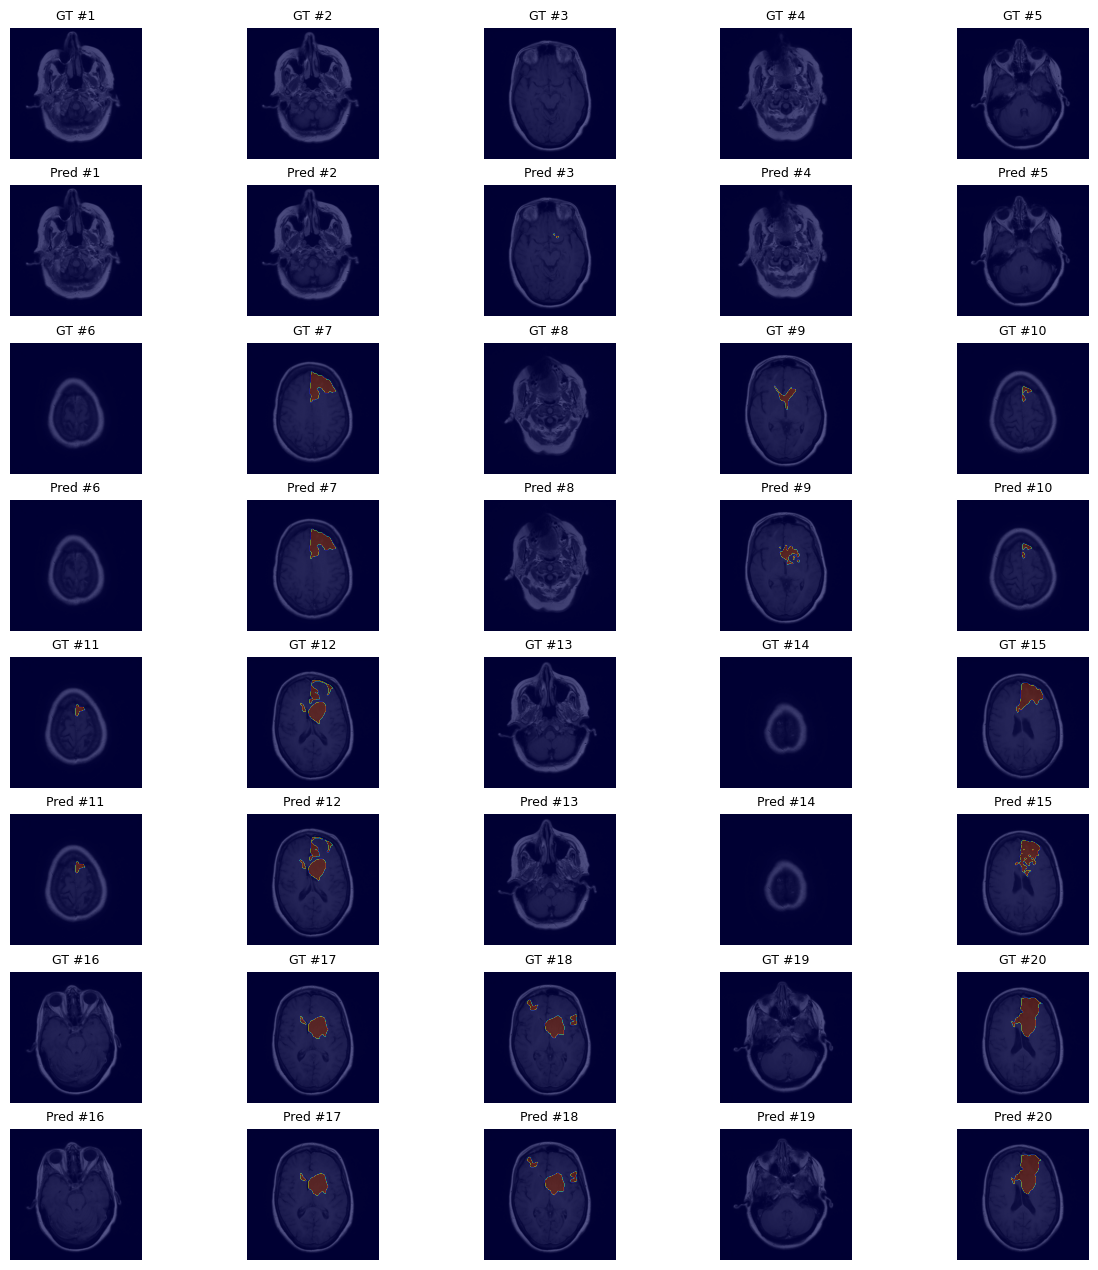

In [52]:
show_predictions_vertical_pairs(model, list(df["images"]), list(df["masks"]), num_groups=20, groups_per_row=5)
